# Objetivo do Projeto

Este é um projeto que utiliza redes neurais convolucionais para realizar previsões de temperatura à partir de do conjunto de dados [Minimum Daily Temperatures Dataset (datasets em Machine Learning Mastery)](https://machinelearningmastery.com/time-series-datasets-for-machine-learning/).

O principal intuito é entender um pouco de como podemos utilizar as redes neurais convolucionais para previsão de séries temporais.

Além disso, estudamos a técnica de bootstrap para estimar intervalos de predição e qual é o nível de confiança deste intervalo.

# Importação de bibliotecas e dados

## Importando principais bibliotecas para o estudo

In [159]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from IPython.display import display

In [160]:
# Importando dados
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
dataset.head()

Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8

## Verificando os dados

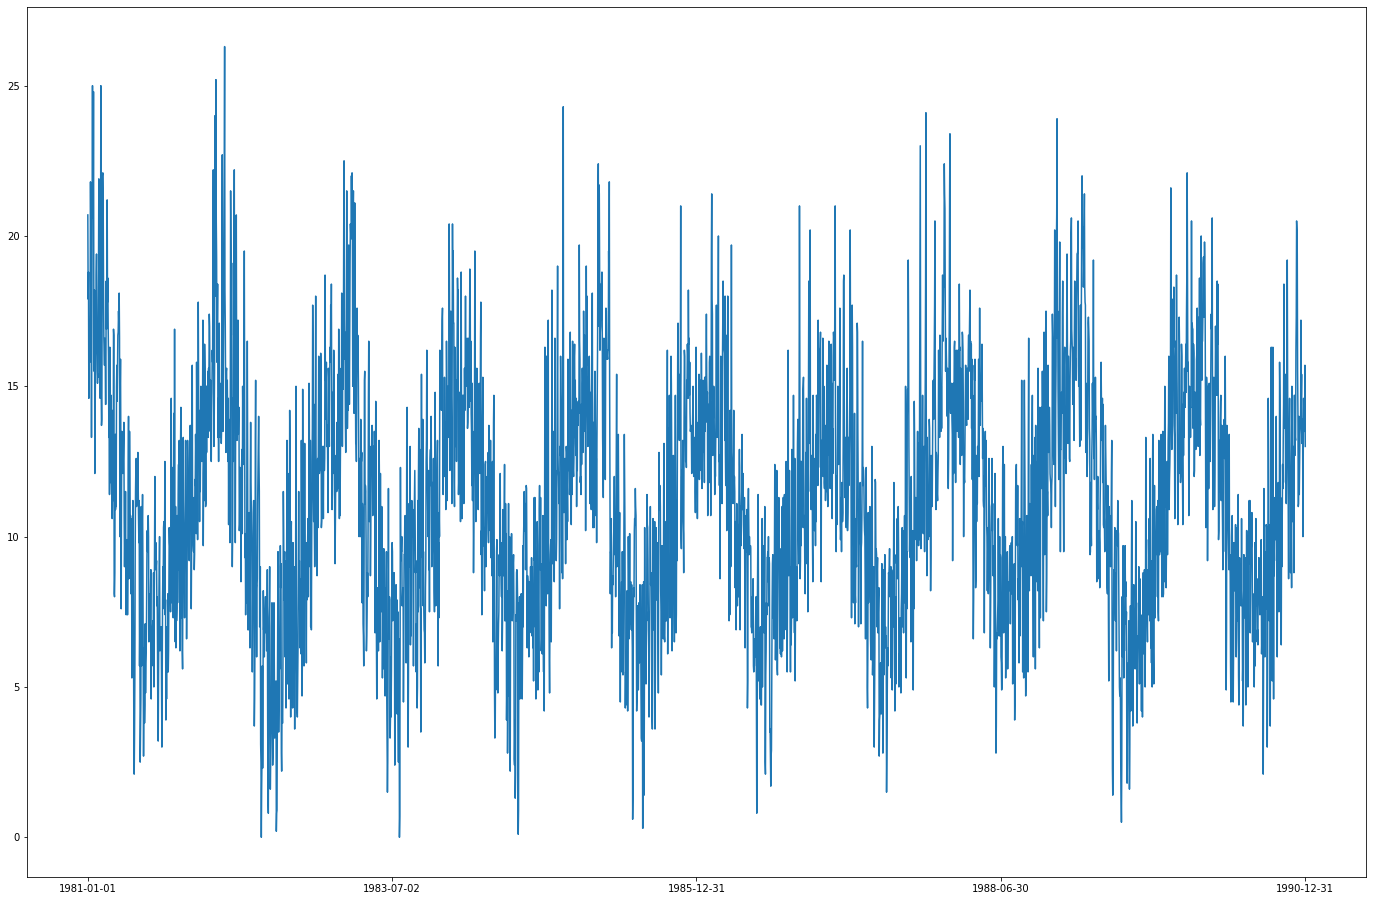

In [161]:
# Plotando dados
fig = plt.figure(figsize=(24,16))

n_examples = len(dataset)

plt.plot(dataset['Date'],dataset['Temp'])

ax = plt.gca()

# Formatando as datas
index = np.linspace(0,n_examples-1,5,dtype='uint16')
ax.set_xticks(dataset['Date'].iloc[index])

plt.show()

## Redes Convolucionais para Séries Temporais

Os modelos de Redes Neurais Convolucionais são um tipo de redes neurais bastante interessante para dados de entrada com relação temporal ou espacial, por exemplo imagens e séries temporais.

Esta rede neural tem vantagem, em geral, possuir menos pesos economizando memória. Além disso, por ser uma série de pequenos cálculos podemos utilizar uma placas gráfica que possui uma série de processadores  (GPU's) com capacidade menor, porém em maior quantidade, permitindo processar vários cálculos em paralelo, acelerando o processamento.

Para melhor compreensão recomendo conhecimentos teóricos sobre como funcionam as redes neurais convolucionais.

Para mais detalhes pode-se consultar as seguintes referências:

[Uma introdução as redes neurais convolucionais utilizando o Keras](https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e)

[Entendendo Redes Convolucionais (CNNs)](https://medium.com/neuronio-br/entendendo-redes-convolucionais-cnns-d10359f21184)

[A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

[Build an Image Classification Model using Convolutional Neural Networks in PyTorch](https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/)


Para o nosso propósito o funcionamento das redes neurais convolucionais para imagens será praticamente o mesmo, só mudando as dimensões dos conjuntos de dados.

A rede neural utilizada tem a seguinte arquitetura:


  Camada 1: 

    (0): Conv1d(in_channels = 1, out_channels = 2, kernel_size=(5,), stride=(1,))

    (1): BatchNorm1d(num_features = 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): GELU()

    (3): Dropout(p=0.25, inplace=False)

    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))


  Camada 2: 
  
    (0): Conv1d(in_channels = 2, out_channels = 4, kernel_size=(5,), stride=(1,))

    (1): BatchNorm1d(num_features = 4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): GELU()

    (3): Dropout(p=0.25, inplace=False)

    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    
    
  Camada 3: 

    (0): Conv1d(in_channels = 4, out_channels = 4, kernel_size=(5,), stride=(1,))

    (1): BatchNorm1d(num_features = 4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): GELU()

    (3): Dropout(p=0.25, inplace=False)

    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    
    
  Camada 4: 

    (0): Conv1d(in_channels = 4, out_channels = 8, kernel_size=(3,), stride=(1,))

    (1): BatchNorm1d(num_features = 8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): GELU()

    (3): Dropout(p=0.25, inplace=False)

    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    
    
  Camada Saída: 

    Linear(in_features=160, out_features=1, bias=True)

## Transformação dos dados

Primeiramente aplicamos as tranformações de escala ``MinMaxScaler``, treinado com os dados de treino e em seguida aplicamos as transformações de escala para o conjunto de dados inteiro.

Para aplicar os modelos precisamos primeiramente transformar um ``numpy.array`` em ``torch.Tensor``. 

Em seguida, precisamos transformar os dados em janelas da série temporal. Mais precisamente, supondo que vamos utilizar uma janela com 5 observações então utilizaremos as 5 observações anteriores para prever o valor. 

Nesse caso teremos que transformar dados da forma de série temporal dado por ``(num_exemplos,1)`` e transformar na forma ``(num_exemplos-tamanho_janela,1,tamanho_janela)`` onde a primeira dimensão corresponde aos exemplos, a segunda corresponde ao número de canais do tensor, que separa cada entrada/saída da convolução em canais diferentes, e a terceira dimensão corresponde à janela de observações.

In [162]:
# Pytorch e pré-processamento
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler



# Formatando os dados de temperatura
y = dataset['Temp']
y = y.astype(float)

y = pd.DataFrame(y)


# Tamanho da sequência utilizada em cada previsão
seq_length = 182



# Número de exemplos
m = len(y)

# A divisão treino e teste é 90%-10%
index = int((m-seq_length)*0.9)
train = y[:index].copy()
test = y[index:].copy()



# Mudança de escala para facilitar o treinamento
sc_y = MinMaxScaler(feature_range=(0,1))

# DataFrame Treino e Teste
train_set = pd.DataFrame(train)
test_set = pd.DataFrame(test)

# Mudança de escala de acordo com os dados de treino
train_sc = sc_y.fit_transform(train_set)
train_sc = pd.Series(train_sc[:,0],index=train_set.index)
test_sc = sc_y.transform(test_set)
test_sc = pd.Series(test_sc[:,0],index=test_set.index)



y_sc = sc_y.transform(y)

In [163]:
# Transformando em tensor
dados = torch.tensor(y_sc)
dados = dados.squeeze(-1)
dados = dados.type(torch.float) 

# Definindo a janela de dados
def Window(data, length_windows):
    # Número de exemplos
    length_data = data.shape[0]
    # Definindo os dados de entrada e as respostas correspondentes
    data_x = torch.zeros(length_data - length_windows, length_windows)
    data_y =  torch.zeros(length_data - length_windows)
    # Adicionando as janelas de dados
    for i in range(length_windows):
        data_x[:,i] = data[i:length_data - length_windows  + i]
    # Definindo as respostas
    data_y = data[length_windows:]
    # Rearanjando as dimensões para aplicar a convolução
    data_y = data_y.unsqueeze(-1)
    data_x = data_x.unsqueeze(1)
    return data_x, data_y

# Número de exemplos
m = len(dados) - seq_length
# Divisão treino-teste de 90%-10%
train_size = int(m * 0.9)
test_size = len(dados) - seq_length - train_size

# Definindo os dados
data_X, data_y = Window(dados, seq_length)
data_y.shape
data_X.shape

torch.Size([3468, 1, 182])

In [164]:
# Divisão Treino-Teste
trainX, trainY  = data_X[:train_size],data_y[:train_size]
testX, testY = data_X[train_size:],data_y[train_size:]

In [192]:
# Barra de progresso
from tqdm.notebook import tqdm

# Verificando se é possível utilizar a GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Entrando com os parâmetros de entrada, retorna o valor de saída de cada camada
def output_size(sequence_length,kernel_size,stride,padding):
  conv_size = int((sequence_length-kernel_size+2*padding)/(stride)) + 1
  pooling_size = int((conv_size)/2)
  return pooling_size


    

class Time_Series(nn.Module):
    def __init__(self,seq_length):
        super(Time_Series, self).__init__()
        # Parâmetros de cada camada
        # Tamanhos de Kernel
        self.conv_kernel_sz = [5,5,5,3]
        # Número de canais (segunda dimensão)
        self.num_channels_out = [2,4,4,8]
        # Padding
        self.padding = [0,0,0,0]
        # Stride
        self.stride = [1,1,1,1]

        # Tamanho da janela de observações
        self.seq_length = seq_length

        # Número de camadas
        n_layers = len(self.conv_kernel_sz)

        # Encontrando o valor de saída de cada camada
        output_size_ConvNet = seq_length
        for i in range(n_layers):
            output_size_ConvNet=output_size(output_size_ConvNet,
                                          kernel_size=self.conv_kernel_sz[i],
                                          stride=self.stride[i],
                                          padding=self.padding[i])
            print('Camada: %d'%(i+1),output_size_ConvNet)
        # Tamanho da última convolução
        self.output_size_ConvNet = output_size_ConvNet
        

        
        # Camada 1
        self.layer1 =  nn.Sequential(nn.Conv1d(in_channels=1,out_channels=self.num_channels_out[0],kernel_size=self.conv_kernel_sz[0],padding=self.padding[0],stride=self.stride[0],groups=1),
                        nn.BatchNorm1d(self.num_channels_out[0]),
                        nn.GELU(),
                        nn.Dropout(0.25),
                        nn.AvgPool1d(2))

        # Camada 2
        self.layer2 =  nn.Sequential(nn.Conv1d(in_channels=self.num_channels_out[0],out_channels=self.num_channels_out[1],kernel_size=self.conv_kernel_sz[1],padding=self.padding[1],stride=self.stride[1],groups=1),
                        nn.BatchNorm1d(self.num_channels_out[1]),
                        nn.GELU(),
                        nn.Dropout(0.25),
                        nn.AvgPool1d(2))

        # Camada 3
        self.layer3 =  nn.Sequential(nn.Conv1d(in_channels=self.num_channels_out[1],out_channels=self.num_channels_out[2],kernel_size=self.conv_kernel_sz[2],padding=self.padding[2],stride=self.stride[2],groups=1),
                        nn.BatchNorm1d(self.num_channels_out[2]),
                        nn.GELU(),
                        nn.Dropout(0.25),
                        nn.AvgPool1d(2))

        # Camada 4
        self.layer4 =  nn.Sequential(nn.Conv1d(in_channels=self.num_channels_out[2],out_channels=self.num_channels_out[3],kernel_size=self.conv_kernel_sz[3],padding=self.padding[3],stride=self.stride[3],groups=1),
                        nn.BatchNorm1d(self.num_channels_out[3]),
                        nn.GELU(),
                        nn.Dropout(0.25),
                        nn.AvgPool1d(2))
        




        # Camada Saída
        self.fc = nn.Linear(self.output_size_ConvNet*self.num_channels_out[-1], 1)

    def forward(self, x):

        # Camada 1
        out = self.layer1(x)
        # Camada 2
        out = self.layer2(out)
        # Camada 3
        out = self.layer3(out)
        # Camada 4
        out = self.layer4(out)
        # Transforma redimensiona as duas últimas dimensões em uma só
        out = out.view(-1,self.output_size_ConvNet*self.num_channels_out[-1])
        # Combina as saídas linearmente
        out = self.fc(out)
        return out 

In [193]:
# Treina a rede neural
def train(model, optimizer, loss_f, num_epochs, batch_size, data_train_x, data_train_y):
    # Lista de valores da loss function no treino
    list_loss = []


        
    # Conta a     
    j = 0
    m = len(data_train_y)
    num_batches = m//batch_size + 1 if m%batch_size>0 else m//batch_size

    num_iterations = num_batches*num_epochs

    
    idx = torch.randperm(m)
    idx = idx[:batch_size]

    alpha = .9
    exponential_decay_loss = []
    loss = loss_f(model(data_train_x[idx]),data_train_y[idx])
    exponential_decay_loss.append(loss.item())
    for epoch in tqdm(range(num_epochs)):
      for i in range(num_batches):
            X_batch = data_train_x[i*batch_size:(i+1)*batch_size]
            y_batch = data_train_y[i*batch_size:(i+1)*batch_size]


            outputs = model(X_batch)
            loss = loss_f(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            list_loss.append(loss.item())
            exponential_decay_loss.append(alpha*exponential_decay_loss[-1] + (1-alpha)*list_loss[-1])


            if j % 50*num_batches == 0:
                print("\nIteration: [%d/%d], Exponentially Smoothed Train Loss: %1.4E" % (j,num_iterations, exponential_decay_loss[-1]))
            j += 1
      
    print('Finished Training Trainset')

    fig=plt.figure(figsize=(12,8))

    ax=fig.add_axes([.1,.1,.85,.85])

    ax.plot(list_loss,c='#0F5CFE',label='Train Loss')
    ax.plot(exponential_decay_loss,c='#6C1AD9',label='Exponentially Smoothed Train Loss')
    ax.set_yscale('log')
    plt.legend()
    plt.show()
    print('Train Loss: %1.4E'% list_loss[-1])
    print('Smoothed Loss: %1.4E'% exponential_decay_loss[-1])
    return [exponential_decay_loss,list_loss]

Batch Size: 525
Camada: 1 89
Camada: 2 42
Camada: 3 19
Camada: 4 8


  0%|          | 0/101 [00:00<?, ?it/s]


Iteration: [0/606], Exponentially Smoothed Train Loss: 4.5263E-01

Iteration: [50/606], Exponentially Smoothed Train Loss: 2.5342E-02

Iteration: [100/606], Exponentially Smoothed Train Loss: 1.4521E-02

Iteration: [150/606], Exponentially Smoothed Train Loss: 1.3702E-02

Iteration: [200/606], Exponentially Smoothed Train Loss: 1.3149E-02

Iteration: [250/606], Exponentially Smoothed Train Loss: 1.2710E-02

Iteration: [300/606], Exponentially Smoothed Train Loss: 1.2737E-02

Iteration: [350/606], Exponentially Smoothed Train Loss: 1.2520E-02

Iteration: [400/606], Exponentially Smoothed Train Loss: 1.2166E-02

Iteration: [450/606], Exponentially Smoothed Train Loss: 1.2360E-02

Iteration: [500/606], Exponentially Smoothed Train Loss: 1.2330E-02

Iteration: [550/606], Exponentially Smoothed Train Loss: 1.2234E-02

Iteration: [600/606], Exponentially Smoothed Train Loss: 1.2189E-02
Finished Training Trainset


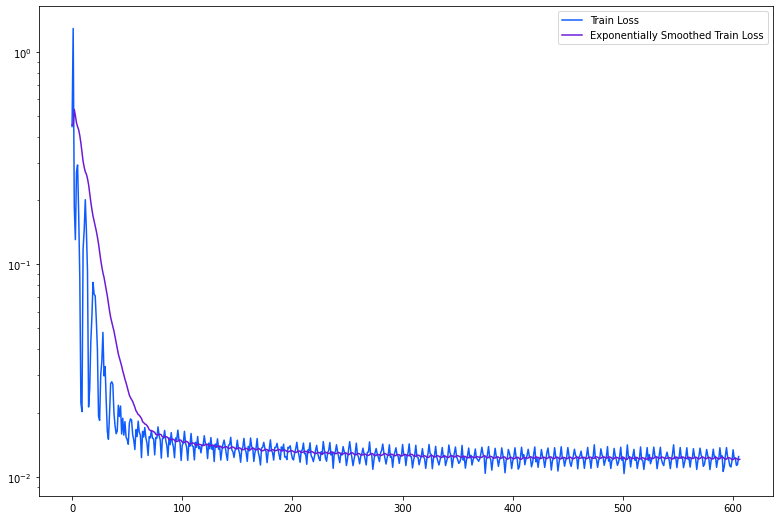

Train Loss: 1.2456E-02
Smoothed Loss: 1.2085E-02


In [194]:
batch_size = len(trainX)//6+5
print('Batch Size: %d'%batch_size)


model = Time_Series(seq_length)

loss_function = torch.nn.MSELoss()
# Hiperparametros
learning_rate = 1e-1
num_epochs = 101

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

[exponential_decay_loss,list_loss] = train(model, optimizer, loss_function, num_epochs, batch_size, trainX, trainY)

In [195]:
torch.save(model.state_dict(),'convolutional_forecast.pt')

In [196]:
# model.load_state_dict(torch.load('convolutional_forecast.pt'))
model

Time_Series(
  (layer1): Sequential(
    (0): Conv1d(1, 2, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): Dropout(p=0.25, inplace=False)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (layer2): Sequential(
    (0): Conv1d(2, 4, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): Dropout(p=0.25, inplace=False)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (layer3): Sequential(
    (0): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): Dropout(p=0.25, inplace=False)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (layer4): Sequential(
    (0): Conv1d(4, 8, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum

In [171]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error



k = 1
data_prediction = np.zeros((len(data_X),k))
for i in range(k):
    prediction = model(data_X)
    data_prediction[:,i:i+1] = prediction.data.numpy()
dataY_plot_sc = data_y.data.numpy()

dataY_base_sc = dataY_plot_sc.copy()
dataY_base = sc_y.inverse_transform(dataY_base_sc)

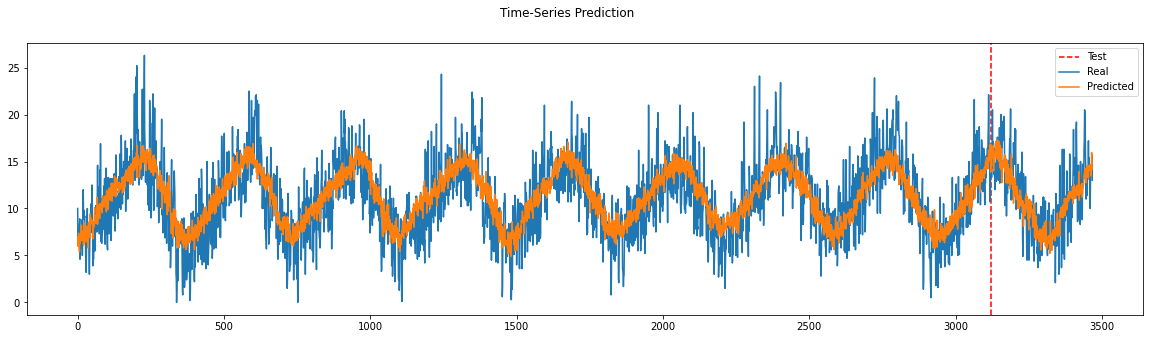

MSE: 8.1
RMSE: 2.85
MAE: 2.25


In [172]:
n = len(dataY_plot_sc)


data_predict_sc = np.median(data_prediction,axis=1,keepdims=True)





dataY_plot = sc_y.inverse_transform(dataY_plot_sc)
data_predict = sc_y.inverse_transform(data_predict_sc)

data_predict_base = data_predict.copy()


MSE=mean_squared_error(dataY_plot,data_predict)
RMSE = np.sqrt(MSE)
MAE=mean_absolute_error(dataY_plot,data_predict)
MAPE=mean_absolute_percentage_error(dataY_plot,data_predict)





plt.figure(figsize=(20,5))
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.legend(["Test","Real","Predicted","Lower","Upper"])
plt.suptitle('Time-Series Prediction')

plt.show()

print('MSE:',np.round(MSE,2))
print('RMSE:',np.round(RMSE,2))
print('MAE:',np.round(MAE,2))

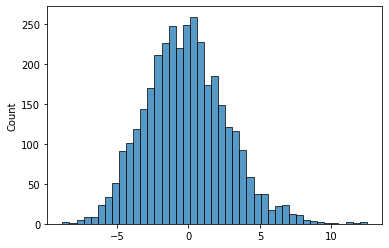

In [173]:
residual = (dataY_plot - data_predict_base).ravel()

sns.histplot(residual)

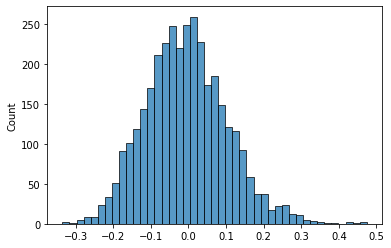

In [174]:
residual_sc = residual*sc_y.scale_
sns.histplot(residual_sc)

## Bootstrap - Intervalo de Previsão



In [175]:
n_sims = 200

simulations = np.zeros((test_size,n_sims))
# Evitar uso desnecessario de memória
with torch.no_grad():
  for j in tqdm(range(n_sims)):
      last_sample = trainX[-1:].clone()
      for i in tqdm(range(test_size), leave=False):
          last_prediction = model(last_sample)

          
          pred = last_prediction.item()
          res = np.random.choice(residual_sc)
          simulations[i,j] = pred + res
          
          
          last_sample[:,:,:-1] = last_sample[:,:,1:].clone()
          last_sample[:,:,-1:] = (last_prediction + res).clone()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

In [176]:
q = 2.5/100
lower_sc = np.quantile(simulations,q,axis=1,keepdims=True)
upper_sc = np.quantile(simulations,1-q,axis=1,keepdims=True)
prediction_sc = np.median(simulations,axis=1,keepdims=True)

upper = sc_y.inverse_transform(upper_sc)
lower = sc_y.inverse_transform(lower_sc)
prediction = sc_y.inverse_transform(prediction_sc)

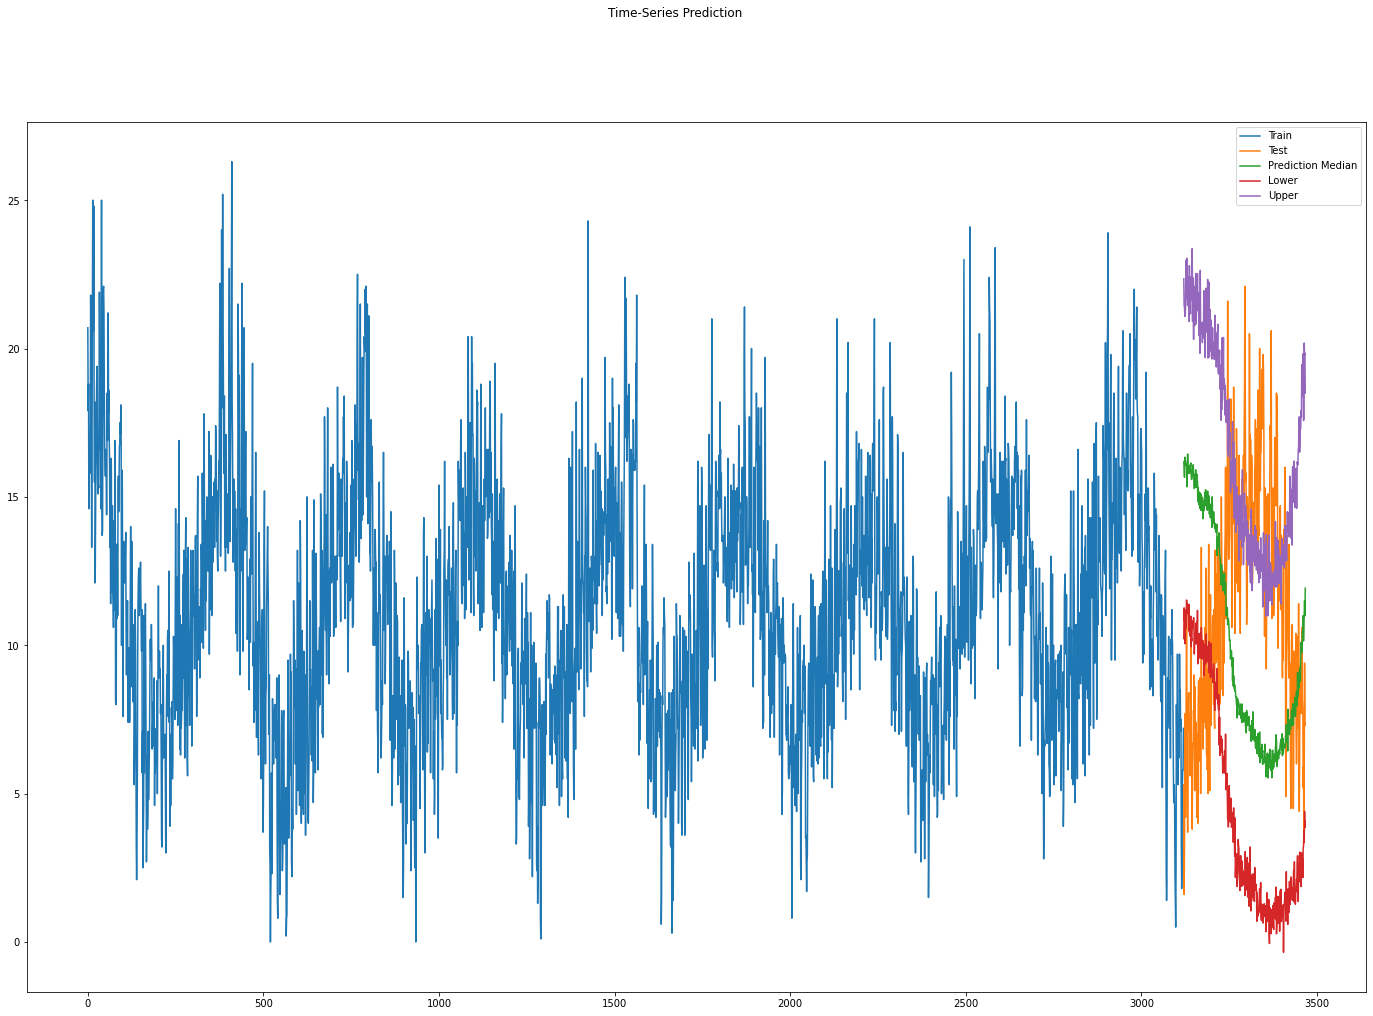

In [177]:
plt.figure(figsize=(24,16))
train_index = list(range(train_size))
test_index = list(range(train_size,m))
plt.plot(train_index,y.iloc[train_index,0])
plt.plot(test_index,y.iloc[test_index,0])
plt.plot(test_index,prediction)
plt.plot(test_index,lower)
plt.plot(test_index,upper)
plt.legend(["Train","Test","Prediction Median","Lower","Upper"])
plt.suptitle('Time-Series Prediction')

plt.show()

## Intervalo de Confiança

Aqui estamos estimando o intervalo de confiança de 95% da previsão estar no intervalo de previsão estipulado nos dados de teste.

Vamos supor que $Y_{i}$ é uma variável aleatória, onde $Y_{i} = 1$ se o valor real está no intervalo de previsão e $Y_{i} = 0$ caso contrário, para cada $i$ no conjunto de teste, então iremos supor que $Y_{i}$ tem uma distribuição Bernoulli com probabilidade de sucesso $p$.

A estimativa através da máxima verossimilhança (Maximum Likelihood) é dada por $\hat{p} = \frac{1}{n_{\text{Teste}}} \sum_{i\in S_{\text{Teste}}} Y_{i}$, onde $n_{\text{Teste}}$ é o número de elementos do conjunto de teste e $S_{\text{Teste}}$ são os índices do conjunto de teste.

Além disso, pela teoria da Máxima Verossimilhança temos que $\hat{p}$ tem distribuição aproximadamente normal com média $p$ e variância de aproximadamente $\frac{p(1-p)}{n_{\text{Teste}}}$. 

Iremos então utilizar a distribuição $t$ para estimar o intervalo de confiança desta de $p$.

In [178]:
from scipy.stats import t

y_test = testY.detach().numpy()
y_test = sc_y.inverse_transform(y_test)
p = (np.logical_and(y_test<=upper,y_test>=lower)).mean()

t_value = t.ppf(1-q,n_sims-1)

p_upper = p + t_value*np.sqrt(p*(1-p)/(n_sims-1))
p_lower = p - t_value*np.sqrt(p*(1-p)/(n_sims-1))
print('Probability of success bounds: [%1.4f,%1.4f]'%(p_lower,p_upper))

Probability of success bounds: [0.8812,0.9574]


# Intervalo de Confiança - Wilson Score

Iremos então utilizar a uma técnica de inferência do intervalo de confiança proposta por Wilson. 

Referência:
[Edwin B. Wilson: Probable Inference, the Law of Succession, and Statistical Inference](https://www.tandfonline.com/doi/abs/10.1080/01621459.1927.10502953)

In [179]:
p_upper = np.max([0.5,p])
p_lower = np.min([0.5,p])

for i in range(200):
  p_upper = p + t_value*np.sqrt(p_upper*(1-p_upper)/(n_sims-1))
  p_lower = p - t_value*np.sqrt(p_lower*(1-p_lower)/(n_sims-1))
print('Probability of success bounds: [%1.4f,%1.4f]'%(p_lower,p_upper))

Probability of success bounds: [0.8727,0.9498]


Então neste caso a chance $p$ de um dado aleatória estar no intervalo de previsão está entre 0.9272 e 0.9821, com 95% de confiança.

# Previsões e Intervalo de confiança

In [180]:
n_sims = 200
n_days = 365

prediction = np.zeros((n_days,1))

with torch.no_grad():
    last_sample = trainX[-1:].clone()
    for i in tqdm(range(n_days), leave=False):
        last_prediction = model(last_sample)

        
        pred = last_prediction.item()
        prediction[i] = pred
        
        last_sample[:,:,:-1] = last_sample[:,:,1:].clone()
        last_sample[:,:,-1:] = (last_prediction).clone()

prediction = sc_y.inverse_transform(prediction)
simulations = np.zeros((n_days,n_sims))
# Evitar uso desnecessario de memória
with torch.no_grad():
  for j in tqdm(range(n_sims)):
      last_sample = trainX[-1:].clone()
      for i in tqdm(range(n_days), leave=False):
          last_prediction = model(last_sample)

          
          pred = last_prediction.item()
          res = np.random.choice(residual_sc)
          simulations[i,j] = pred + res
          
          
          last_sample[:,:,:-1] = last_sample[:,:,1:].clone()
          last_sample[:,:,-1:] = (last_prediction + res).clone()

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

In [181]:
q = 2.5/100
lower_sc = np.quantile(simulations,q,axis=1,keepdims=True)
upper_sc = np.quantile(simulations,1-q,axis=1,keepdims=True)

upper = sc_y.inverse_transform(upper_sc)
lower = sc_y.inverse_transform(lower_sc)

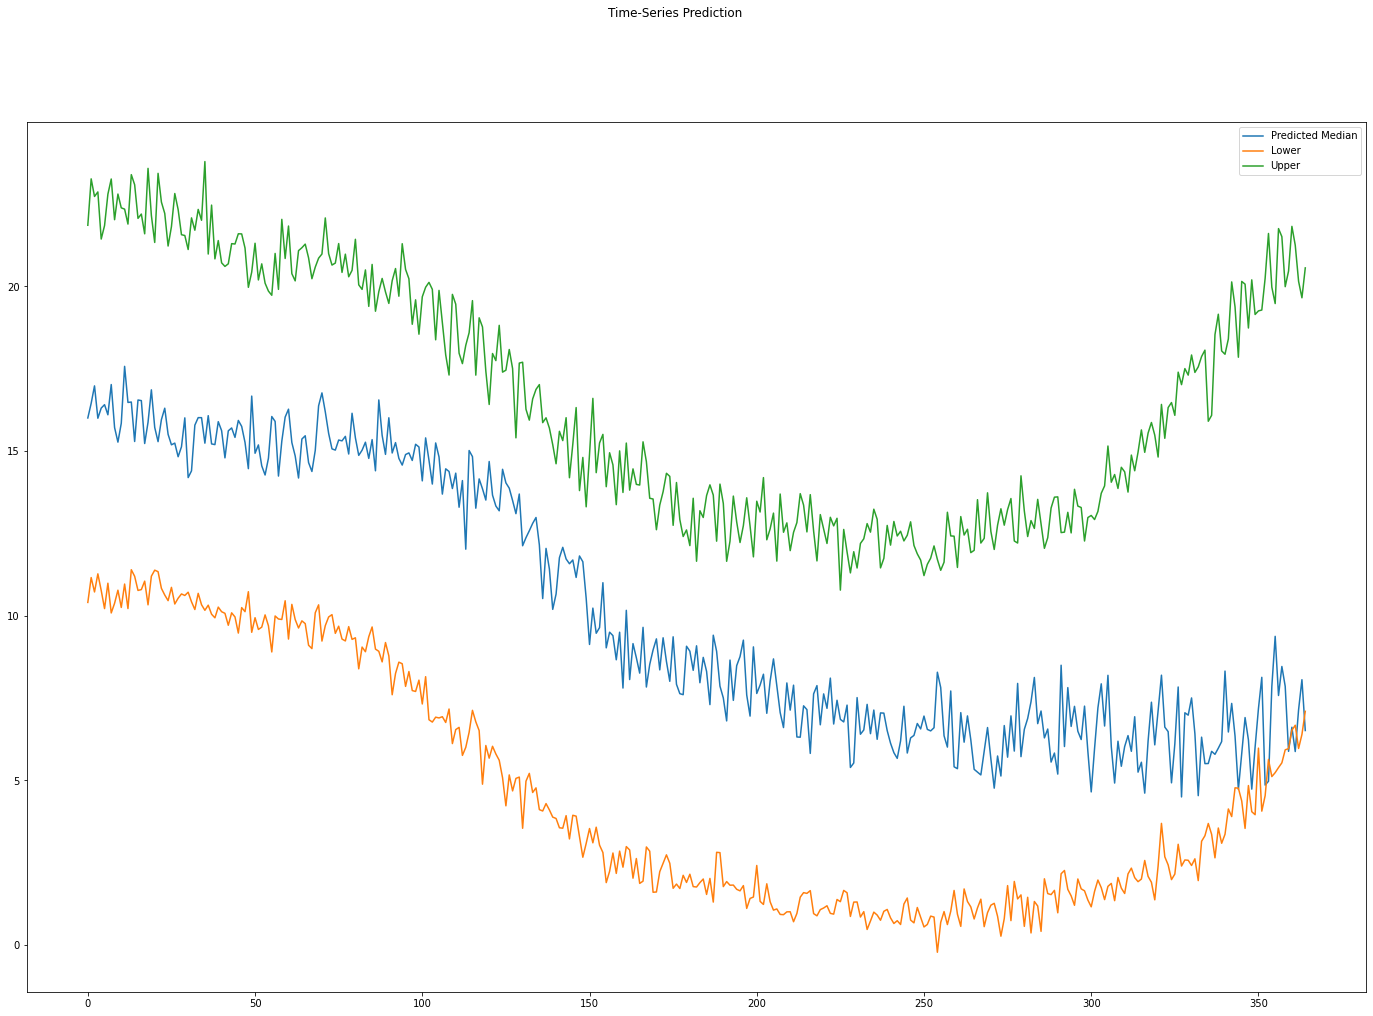

In [182]:
plt.figure(figsize=(24,16))
plt.plot(prediction)
plt.plot(lower)
plt.plot(upper)
plt.legend(["Predicted Median","Lower","Upper"])
plt.suptitle('Time-Series Prediction')

plt.show()